In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from talib import abstract
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
from sklearn.tree import export_graphviz
import graphviz 
from sklearn.tree import DecisionTreeClassifier  # 決策樹分類器
from sklearn.feature_selection import mutual_info_regression as mir
from sklearn.metrics import confusion_matrix # 混淆矩陣
from sklearn.metrics import roc_curve, auc #計算 AUC 的話，要從 metrics 裡匯入 roc_curve 以及 auc
import matplotlib.pyplot as plt
import pickle

In [6]:
import yfinance as yf

stk = yf.Ticker('2330.TW')
# 取得 2000 年至今的資料
data = stk.history(start = '2000-01-01')
# 簡化資料，只取開、高、低、收以及成交量
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]

In [7]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2000-01-04 00:00:00+08:00,34.216969,34.216969,33.640283,34.216969,200662336736
2000-01-05 00:00:00+08:00,34.216960,34.985813,33.832441,34.985813,402466805912
2000-01-06 00:00:00+08:00,34.793655,34.985822,34.216969,34.216969,197545715802
2000-01-07 00:00:00+08:00,33.063589,33.640275,32.679070,33.255756,235270344752
2000-01-10 00:00:00+08:00,34.216963,34.601298,33.640277,34.409130,276171685539
...,...,...,...,...,...
2024-09-12 00:00:00+08:00,936.000000,944.000000,928.000000,940.000000,39454846
2024-09-13 00:00:00+08:00,955.000000,955.000000,939.000000,947.000000,25347586
2024-09-16 00:00:00+08:00,952.000000,952.000000,943.000000,947.000000,13626239


In [3]:
data.to_csv('2330股價.csv')

In [4]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2000-01-04 00:00:00+08:00,34.216965,34.216965,33.640279,34.216965,200662336736
2000-01-05 00:00:00+08:00,34.216964,34.985817,33.832445,34.985817,402466805912
2000-01-06 00:00:00+08:00,34.793651,34.985818,34.216965,34.216965,197545715802
2000-01-07 00:00:00+08:00,33.063585,33.640271,32.679067,33.255753,235270344752
2000-01-10 00:00:00+08:00,34.216959,34.601294,33.640273,34.409126,276171685539
...,...,...,...,...,...
2024-09-12 00:00:00+08:00,936.000000,944.000000,928.000000,940.000000,39454846
2024-09-13 00:00:00+08:00,955.000000,955.000000,939.000000,947.000000,25347586
2024-09-16 00:00:00+08:00,952.000000,952.000000,943.000000,947.000000,13626239


In [5]:
# data2 = pd.read_csv('2330股價.csv',index_col='Date')
# data2.index = pd.to_datetime(data2.index)

In [6]:
# 改成 TA-Lib 可以辨識的欄位名稱
data.columns = ['open','high','low','close','volume']
# 隨意試試看這幾個因子好了
ta_list = ['AVGPRICE','BBANDS','BETA','BOP','CCI','CDL2CROWS',
           'CDL3BLACKCROWS','CDL3INSIDE','CDL3LINESTRIKE',
           'CDL3STARSINSOUTH','CDL3WHITESOLDIERS','CDLABANDONEDBABY',
           'CDLADVANCEBLOCK','CDLBELTHOLD','CDLBREAKAWAY',
           'CDLCLOSINGMARUBOZU','CDLCONCEALBABYSWALL','CDLCOUNTERATTACK',
           'CDLDARKCLOUDCOVER','CDLDOJI','CDLDOJISTAR','CDLDRAGONFLYDOJI',
           'CDLENGULFING','CDLEVENINGDOJISTAR','CDLEVENINGSTAR','CDLGAPSIDESIDEWHITE',
           'CDLGRAVESTONEDOJI','CDLHAMMER','CDLHANGINGMAN','CDLHARAMI','CDLHARAMICROSS',
           'CDLHIGHWAVE','CDLHIKKAKE','CDLHIKKAKEMOD','CDLHOMINGPIGEON','CDLIDENTICAL3CROWS',
           'CDLINNECK','CDLINVERTEDHAMMER','CDLKICKING','CDLKICKINGBYLENGTH','CDLLADDERBOTTOM',
           'CDLLONGLEGGEDDOJI','CDLLONGLINE','CDLMARUBOZU','CDLMATCHINGLOW','CDLMATHOLD','CDLMORNINGDOJISTAR',
           'CDLMORNINGSTAR','CDLONNECK','CDLPIERCING','CDLRICKSHAWMAN','CDLRISEFALL3METHODS','CDLSEPARATINGLINES',
           'CDLSHOOTINGSTAR','CDLSHORTLINE','CDLSPINNINGTOP','CDLSTALLEDPATTERN','CDLSTICKSANDWICH','CDLTAKURI',
           'CDLTASUKIGAP','CDLTHRUSTING','CDLTRISTAR','CDLUNIQUE3RIVER','CDLUPSIDEGAP2CROWS','CDLXSIDEGAP3METHODS',
           'CMO','CORREL','DEMA','DX','EMA','HT_DCPERIOD','HT_DCPHASE','HT_PHASOR','HT_SINE','HT_TRENDLINE','HT_TRENDMODE',
           'KAMA','LINEARREG','LINEARREG_ANGLE','LINEARREG_INTERCEPT','LINEARREG_SLOPE','MA','MACD','MACDEXT','MACDFIX',
           'MAMA','MAX','MAXINDEX','MEDPRICE','MFI','MIDPOINT','MIDPRICE','MIN','MININDEX','MINMAX','MINMAXINDEX','MINUS_DI',
           'MINUS_DM','MOM','NATR','OBV','PLUS_DI','PLUS_DM','PPO','ROC','ROCP','ROCR','ROCR100','RSI','SAR','SAREXT','SMA',
           'STDDEV','STOCH','STOCHF','STOCHRSI','SUM','T3','TEMA','TRANGE','TRIMA','TRIX','TSF','TYPPRICE','ULTOSC','VAR',
           'WCLPRICE','WILLR','WMA'
]
# 快速計算與整理因子
for x in ta_list:
    output = eval('abstract.'+x+'(data)')
    output.name = x.lower() if type(output) == pd.core.series.Series else None
    data = pd.merge(data, pd.DataFrame(output), left_on = data.index, right_on = output.index)
    data = data.set_index('key_0')

In [7]:
# 五日後漲標記 1，反之標記 0
data['week_trend'] = np.where(data.close.shift(-5) > data.close, 1, 0)

C:\Users\user\AppData\Local\Temp\ipykernel_12016\2721318654.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot_date(t, y, 'b-', color = 'black')
C:\Users\user\AppData\Local\Temp\ipykernel_12016\2721318654.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df.week_trend[i] == 1:


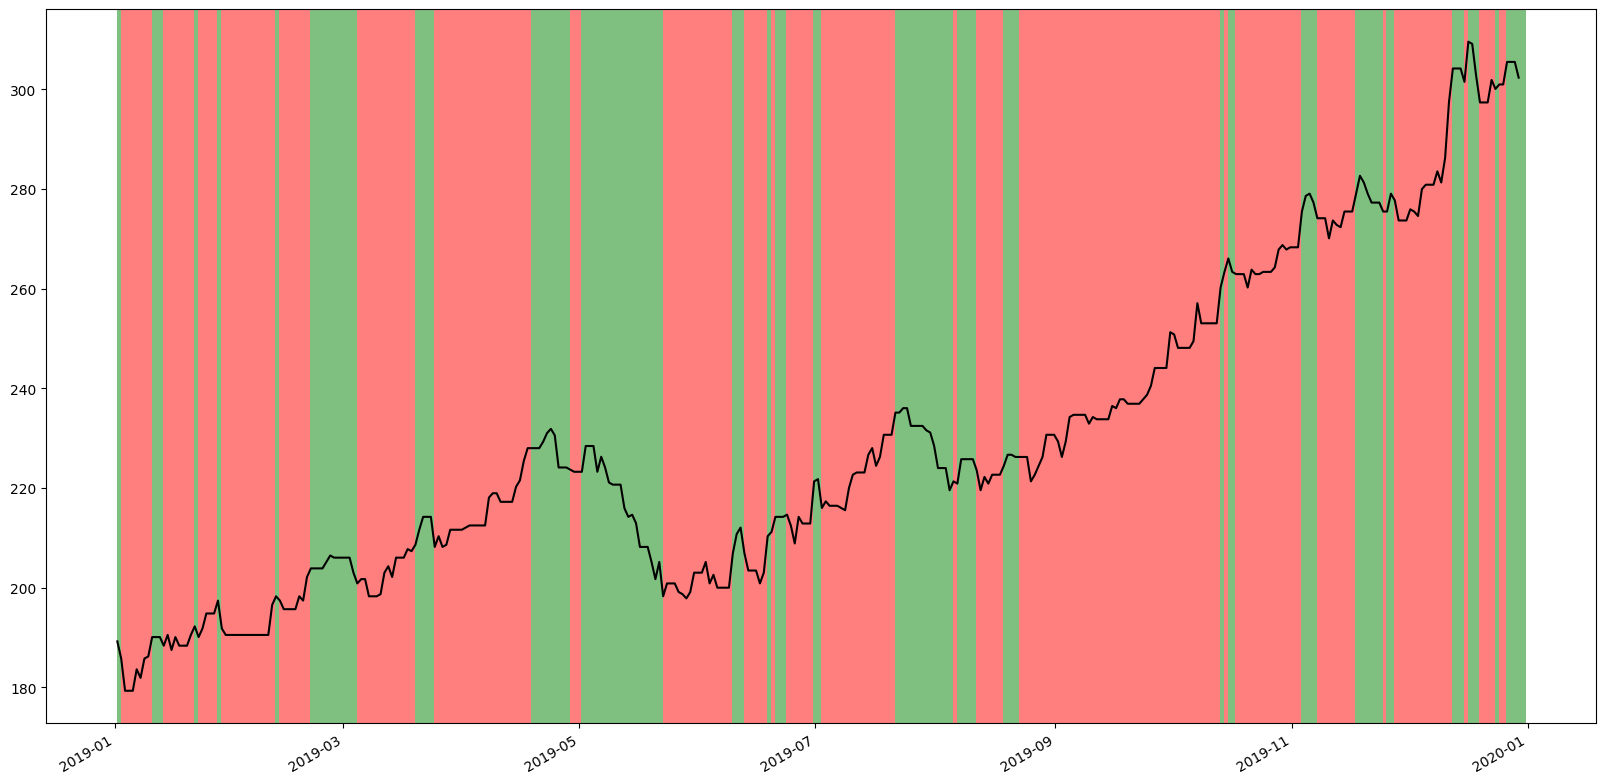

In [8]:
start_date = '2019-01-01'
end_date = '2019-12-31'
df = data.loc[start_date:end_date].copy()

df = df.resample('D').ffill()

t = mdates.drange(df.index[0], df.index[-1], dt.timedelta(hours = 24))
y = np.array(df.close[:-1])

fig, ax = plt.subplots()
ax.plot_date(t, y, 'b-', color = 'black')
for i in range(len(df)):
    if df.week_trend[i] == 1:
        ax.axvspan(
            mdates.datestr2num(df.index[i].strftime('%Y-%m-%d')) - 0.5,
            mdates.datestr2num(df.index[i].strftime('%Y-%m-%d')) + 0.5,
            facecolor = 'red', edgecolor = 'none', alpha = 0.5
            )
    else:
        ax.axvspan(
            mdates.datestr2num(df.index[i].strftime('%Y-%m-%d')) - 0.5,
            mdates.datestr2num(df.index[i].strftime('%Y-%m-%d')) + 0.5,
            facecolor = 'green', edgecolor = 'none', alpha = 0.5
            )
fig.autofmt_xdate()
fig.set_size_inches(20, 10.5)
fig.savefig('define_y.png')

In [9]:
# 檢查資料有無缺值
data.isnull().sum()
# 最簡單的作法是把有缺值的資料整列拿掉
data = data.dropna()

In [10]:
# top_features = pd.DataFrame(mir(X, y), index=X.columns).sort_values(by=0, ascending=False)
# top_features.head(20)

In [11]:
# 決定切割比例為 70%:30%
split_point = int(len(data)*0.7)
# 切割成學習樣本以及測試樣本
train = data.iloc[:split_point,:].copy()
test = data.iloc[split_point:-5,:].copy()

In [12]:
# 訓練樣本再分成目標序列 y 以及因子矩陣 X
train_X = train.drop('week_trend', axis = 1)
train_y = train.week_trend
# 測試樣本再分成目標序列 y 以及因子矩陣 X
test_X = test.drop('week_trend', axis = 1)
test_y = test.week_trend

In [13]:
# 叫出一棵決策樹
model = DecisionTreeClassifier(max_depth = 10)

In [14]:
model.fit(train_X, train_y)

# 讓 A.I. 測驗，prediction 存放了 A.I. 根據測試集做出的預測
prediction = model.predict(test_X)

In [15]:
dot_data = export_graphviz(model, out_file = None,
                           feature_names = train_X.columns,
                           filled = True, rounded = True,
                           class_names = True,
                           special_characters = True)
graph = graphviz.Source(dot_data)

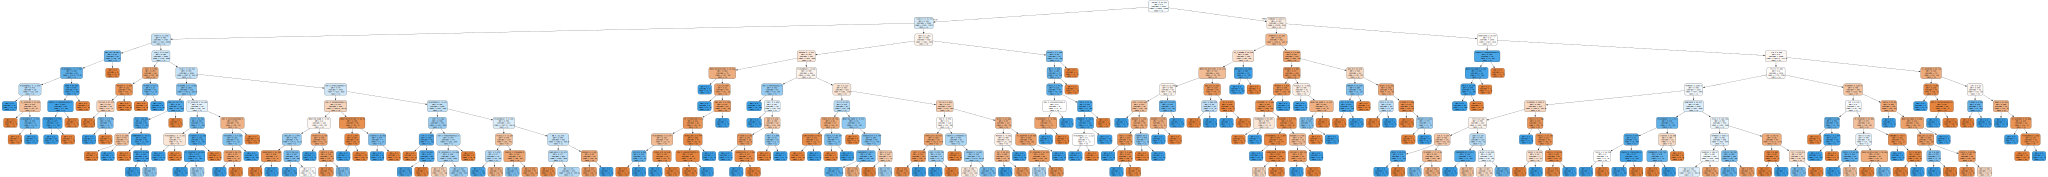

In [16]:
graph

In [17]:
# 混淆矩陣
confusion_matrix(test_y, prediction)

# 準確率
model.score(test_X, test_y)

0.5016519823788547

In [18]:
# 計算 ROC 曲線
false_positive_rate, true_positive_rate, thresholds = roc_curve(test_y, prediction)

# 計算 AUC 面積
auc(false_positive_rate, true_positive_rate)

0.5047774959424258

In [19]:
false_positive_rate

array([0.        , 0.45738295, 1.        ])

In [20]:
true_positive_rate

array([0.        , 0.46693795, 1.        ])

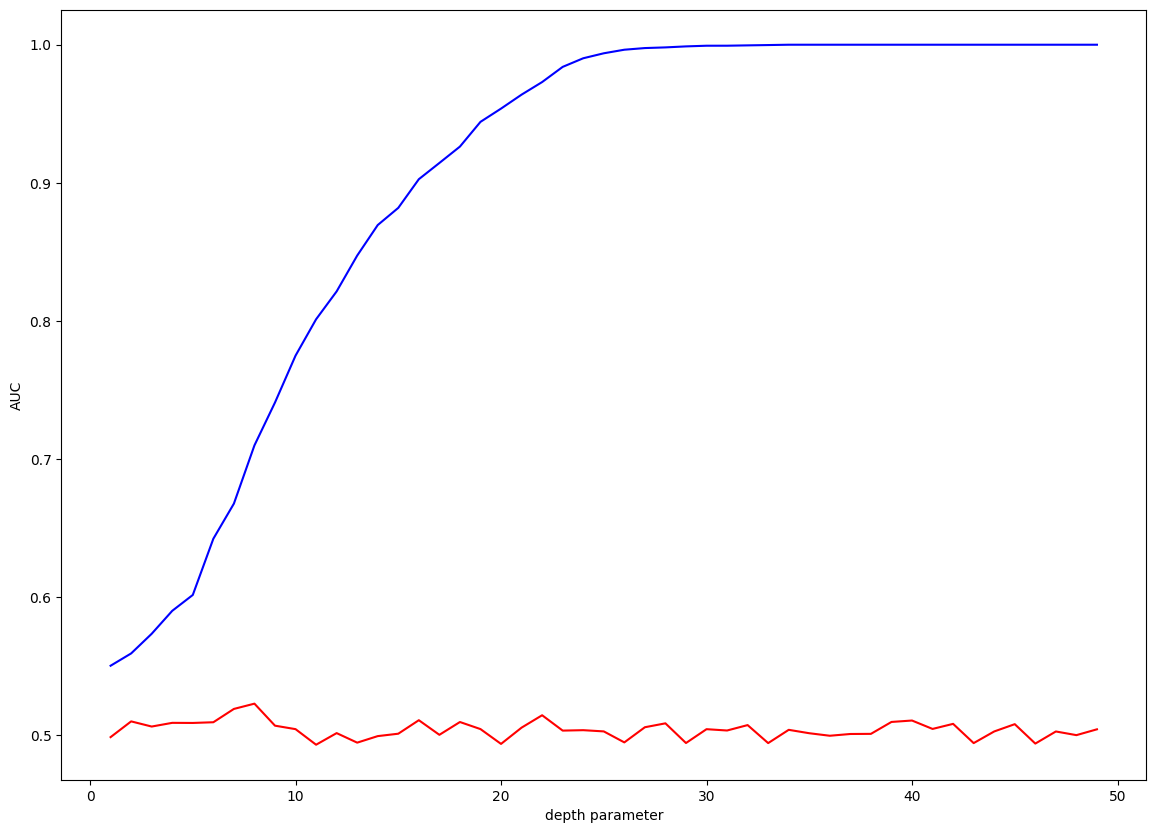

In [21]:
# 測試一批深度參數，一般而言深度不太會超過 3x，我們這邊示範 1 到 50 好了
depth_parameters = np.arange(1, 50)
# 準備兩個容器，一個裝所有參數下的訓練階段 AUC；另一個裝所有參數下的測試階段 AUC
train_auc= []
test_auc = []
# 根據每一個參數跑迴圈
for test_depth in depth_parameters:
    # 根據該深度參數，創立一個決策樹模型，取名 temp_model
    temp_model = DecisionTreeClassifier(max_depth = test_depth)
    # 讓 temp_model 根據 train 學習樣本進行學習
    temp_model.fit(train_X, train_y)
    # 讓學習後的 temp_model 分別根據 train 學習樣本以及 test 測試樣本進行測驗
    train_predictions = temp_model.predict(train_X)
    test_predictions = temp_model.predict(test_X)
    # 計算學習樣本的 AUC，並且紀錄起來
    false_positive_rate, true_positive_rate, thresholds = roc_curve(train_y, train_predictions)
    auc_area = auc(false_positive_rate, true_positive_rate)
    train_auc.append(auc_area)
    # 計算測試樣本的 AUC，並且紀錄起來
    false_positive_rate, true_positive_rate, thresholds = roc_curve(test_y, test_predictions)
    auc_area = auc(false_positive_rate, true_positive_rate)
    test_auc.append(auc_area)

# 繪圖視覺化
plt.figure(figsize = (14,10))
plt.plot(depth_parameters, train_auc, 'b', label = 'Train AUC')
plt.plot(depth_parameters, test_auc, 'r', label = 'Test AUC')
plt.ylabel('AUC')
plt.xlabel('depth parameter')
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_12016\1677694913.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test['buy_cost'] = test.open[np.where((test.status == 1) * (test.status.shift(1) == 0))[0]]
C:\Users\user\AppData\Local\Temp\ipykernel_12016\1677694913.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test['sell_cost'] = test.open[np.where((test.status == 0) * (test.status.shift(1) == 1))[0]]
C:\Users\user\AppData\Local\Temp\ipykernel_12016\1677694913.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1.84695677e-02 -1.30208515

<Axes: xlabel='key_0'>

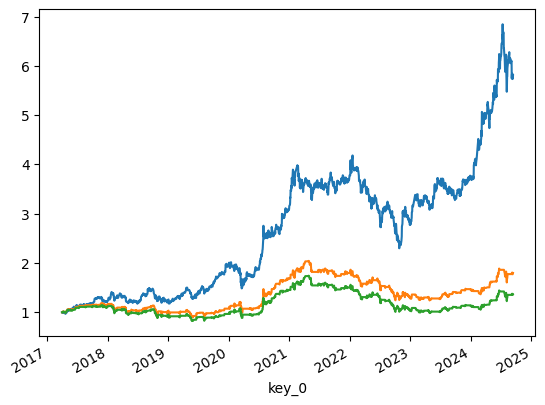

In [22]:
# test 是我們在切割樣本的時候，切出來的測試樣本，包含了價量資訊，我們首先將 A.I. 在這期間的預測結果 prediction 放進去
test['prediction'] = prediction

# 這次的二元分類問題很單純，若直接把 prediction 位移一天，剛好就會是模擬買賣的狀況：
# T-1 日的預測為「跌」而 T 日的預測為「漲」，則 T+1 日開盤『買進』
# T-1 日的預測為「漲」而 T 日的預測為「跌」，則 T+1 日開盤『賣出』
# 連續預測「漲」，則『持續持有』
# 連續預測「跌」，則『空手等待』
test['status'] = test.prediction.shift(1).fillna(0)

# 所以什麼時候要買股票就很好找了：status 從 0 變成 1 的時候，1 的那天的開盤買進（因為 status 已經位移一天了喔）
# 從 prediction 的角度解釋就是：當 A.I. 的預測從 0 變成 1 的時候，1 的隔天的開盤買進
test['buy_cost'] = test.open[np.where((test.status == 1) * (test.status.shift(1) == 0))[0]]
# 同理，賣股票也很好找：status 從 1 變成 0 的時候，0 的那天的開盤賣出
test['sell_cost'] = test.open[np.where((test.status == 0) * (test.status.shift(1) == 1))[0]]
# 把缺值補上 0
test = test.fillna(0)

# 來算算每次買賣的報酬率吧！
# 一買一賣是剛好對應的，所以把買的成本以及賣的價格這兩欄的數字取出，就能輕易的算出交易報酬率

buy_cost = np.array(test.buy_cost[test.buy_cost != 0])
sell_price = np.array(test.sell_cost[test.sell_cost != 0])

# 但是回測的最後一天，有時候會發現還有持股尚未賣出喔！由於還沒賣就不能當作一次完整的交易，
# 所以最後一次的買進，我們先忽略
if len(buy_cost) > len(sell_price) :
    buy_cost = buy_cost[:-1]

trade_return = sell_price / buy_cost - 1

# 交易都會有交易成本，例如台股每次一買一賣約產生 0.6% 的交易成本。
# 買賣 SPY ETF 也會有交易成本，管理費用約 0.1%，券商手續費因人而異，但近年來此費用逐漸趨近於 0，這裡就假設 0.1% 手續費好了
# 因此這裡額外計算一個把每次交易報酬率扣除總交易成本約 0.2% 的淨報酬率
fee = 0.002
net_trade_return = trade_return - fee

# 把報酬率都放進表格吧！
test['trade_ret'] = 0
test['net_trade_ret'] = 0
sell_dates = test.sell_cost[test.sell_cost != 0].index
test.loc[sell_dates, 'trade_ret'] = trade_return
test.loc[sell_dates, 'net_trade_ret'] = net_trade_return

# 如果還想要畫出績效走勢圖，那就要把策略的報酬率也算出來，由於我們不論買賣都是以開盤價進行，所以策略的報酬率會使用開盤價計算
test['open_ret'] = test.open / test.open.shift(1) - 1
test['strategy_ret'] = test.status.shift(1) * test.open_ret
test['strategy_net_ret'] = test.strategy_ret
test.loc[sell_dates, 'strategy_net_ret'] = test.loc[sell_dates, 'strategy_net_ret'] - fee
test = test.fillna(0)

# 計算出績效走勢圖
test['buy_and_hold_equity'] = (test.open_ret + 1).cumprod()
test['strategy_equity'] = (test.strategy_ret + 1).cumprod()
test['strategy_net_equity'] = (test.strategy_net_ret + 1).cumprod()

# 計算出一些有用的策略績效數字吧！
trade_count = len(sell_dates)
trade_count_per_year = trade_count / (len(test)/252)
win_rate = (net_trade_return > 0).sum() / trade_count
profit_factor = net_trade_return[net_trade_return > 0].sum() / abs(net_trade_return[net_trade_return < 0].sum())
mean_net_return = np.mean(net_trade_return)
acc_ret = test.strategy_net_equity[-1] - 1
strategy_ear = test.strategy_net_equity[-1] ** (252/len(test)) - 1
strategy_std = test.strategy_net_ret.std() * (252 ** 0.5)
strategy_sharpe = (strategy_ear - 0.01) / strategy_std

# 也畫出績效走勢看看吧！
test.buy_and_hold_equity.plot()
test.strategy_equity.plot()
test.strategy_net_equity.plot()

In [23]:
test

,open,high,low,close,volume,avgprice,upperband,middleband,lowerband,beta,...,buy_cost,sell_cost,trade_ret,net_trade_ret,open_ret,strategy_ret,strategy_net_ret,buy_and_hold_equity,strategy_equity,strategy_net_equity
key_0,,,,,,,,,,,,,,,,,,,,,
2017-03-30 00:00:00+08:00,154.929968,155.332384,153.320306,154.125137,28302000,154.426949,156.802944,155.010471,153.217997,0.310063,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
2017-03-31 00:00:00+08:00,153.722730,154.527561,152.113068,152.113068,33635000,153.119106,157.388870,154.447083,151.505295,0.463046,...,0.000000,0.000000,0.000000,0.000000,-0.007792,-0.000000,-0.000000,0.992208,1.000000,1.000000
2017-04-05 00:00:00+08:00,152.515489,155.332397,152.515489,155.332397,43748000,153.923943,157.388870,154.447083,151.505295,0.709026,...,152.515489,0.000000,0.000000,0.000000,-0.007853,-0.000000,-0.000000,0.984416,1.000000,1.000000
2017-04-06 00:00:00+08:00,155.332384,155.332384,153.722722,154.125137,16173000,154.628157,156.038081,153.964175,151.890269,0.797005,...,0.000000,155.332384,0.018470,0.016470,0.018470,0.018470,0.016470,1.002597,1.018470,1.016470
2017-04-07 00:00:00+08:00,154.527564,154.527564,151.710655,153.722733,18911000,153.622129,155.957600,153.883694,151.809788,1.017655,...,154.527564,0.000000,0.000000,0.000000,-0.005181,-0.000000,-0.000000,0.997403,1.018470,1.016470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-05 00:00:00+08:00,902.973347,910.937831,896.004423,897.995544,30512026,901.977786,968.770745,920.495215,872.219685,1.095883,...,0.000000,0.000000,0.000000,0.000000,0.014541,0.014541,0.014541,5.828268,1.800764,1.372710
2024-09-06 00:00:00+08:00,904.964455,913.924500,898.991093,913.924500,24458336,907.951137,959.583906,915.318298,871.052691,1.102275,...,0.000000,0.000000,0.000000,0.000000,0.002205,0.002205,0.002205,5.841119,1.804735,1.375737
2024-09-09 00:00:00+08:00,888.039927,896.004411,887.044366,895.008850,35885268,891.524389,941.059633,905.561804,870.063976,1.079814,...,0.000000,0.000000,0.000000,0.000000,-0.018702,-0.018702,-0.018702,5.731880,1.770983,1.350008


In [24]:
print(f"trade_count: {trade_count}")
print(f"trade_count_per_year: {trade_count_per_year}")
print(f"win_rate: {win_rate:.2f}")
print(f"profit_factor: {profit_factor:.2f}")
print(f"mean_net_return: {mean_net_return:.2f}")
print(f"acc_ret: {acc_ret:.2f}")
print(f"strategy_ear: {strategy_ear:.2f}")
print(f"strategy_std: {strategy_std:.2f}")
print(f"strategy_sharpe: {strategy_sharpe:.2f}")

trade_count: 137
trade_count_per_year: 19.01101321585903
win_rate: 0.59
profit_factor: 1.25
mean_net_return: 0.00
acc_ret: 0.37
strategy_ear: 0.04
strategy_std: 0.20
strategy_sharpe: 0.17


In [25]:
# 儲存模型
filename = 'Decision_Tree_model_001.sav'
pickle.dump(model, open(filename, 'wb'))

# 取出模型
filename = 'Decision_Tree_model_001.sav'
model = pickle.load(open(filename, 'rb'))

In [26]:
model

DecisionTreeClassifier(max_depth=10)